<a href="https://colab.research.google.com/github/ali-h2010/Image_Classifier_Project_Udacity_2020_ML/blob/master/Efad_imageProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faedh's Team contribution to Efad volunteer initiative

## What is Efad initiative?
Efad is a Volunteer initiatives that aims to create open source Arabic databases ,tools ,algorithms, and applications 
that will help researchers and people who are interested in converting handwritten text to digital text that can be worked with in machines and text editors.

# Faedh Team:
We are a team of IT specialists that love technology and love to contribute and volunteer to our field and innovate on others.

#### Curretnly the team consist of:
1. Ali 
2. Aljawharah
3. Shahad

# This Notebook:
This notebook will be used to preprocess the images and try to figure out 
the best approches and techniques to segment the text. We will try to achieve 

#Imports

In [22]:
import os
import matplotlib.pyplot as plt
from PIL import Image as ImagePIL
from PIL import ImageEnhance,ImageOps,ImageDraw,ImageFilter
import glob # allow using globs of images using *
import numpy as np
import cv2
from matplotlib import cm
from IPython.display import HTML, display
import tabulate
import statistics
%matplotlib inline

# Choose Resolution of the inline images in this notebook

In [27]:
plt.rcParams['figure.dpi'] = 250

# What Needs to be done:
We need to convert paragraphs and multiple texts into workds and save them with a unique name such as:
`FileName_4DigitsIncreasingNumber_.tiff`

## Example of what needed to be Done
We will load the image from Google Drive directly. This time it was loaded from local files just for testing


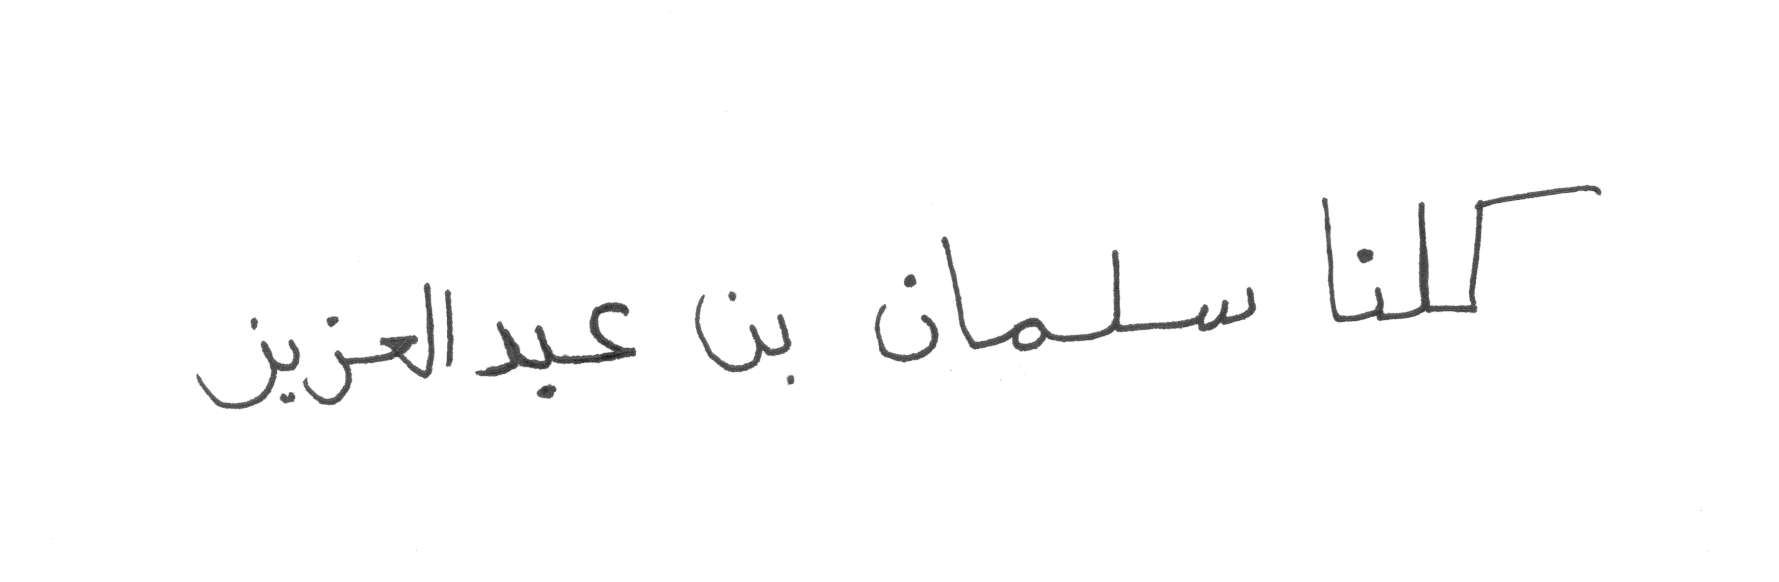

In [4]:
train_dir = '/content'
img =  ImagePIL.open(train_dir + '/' + 'KSA_croped.png').convert('RGB')
display(img)

We need to divide the above senetence into words. In this case the word was:

`كلنا سلمان بن عبدالعزيز`

In this case, the sentence will be divided into 4 words:

`كلنا`

`سلمان`

`بن`

`عبدالعزيز`

Basically, what we need to do is to figure out the dimensions that represent the word in that full image and create a cropped image from that sentence. 

## Displaying Properties of the image
1. Size
2. Format
3. Mode (HSV,RGB,BGR, etc)

In [ ]:
print('Size: {}'.format(img.size)) # width * height
print('Mode: {}'.format(img.mode)) # (HSV,RGB,BGR, etc)
print('Format: {}'.format(img.format)) # the file format of the source file png,tiff,...

Size: (1779, 582)
Mode: RGB
Format: None


In [ ]:
ColorsInImage = img.getcolors() # returns an unsorted list of (count, pixel) values.

In [ ]:
copyOfImg = img.copy()

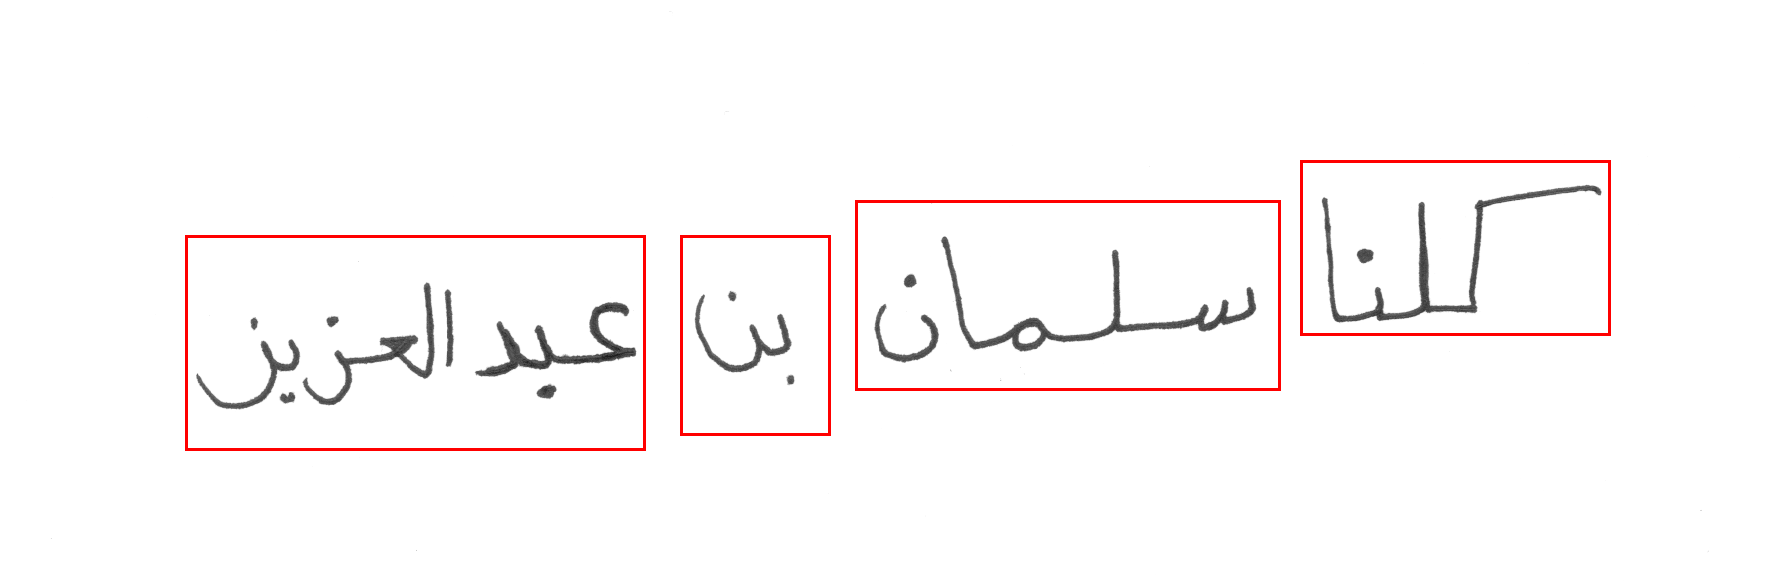

In [ ]:
ImageDraw.Draw(copyOfImg).rectangle([(185,235),(645,450)], outline="red",width=3)
ImageDraw.Draw(copyOfImg).rectangle([(680,235),(830,435)], outline="red",width=3) 
ImageDraw.Draw(copyOfImg).rectangle([(855,200),(1280,390)], outline="red",width=3) 
ImageDraw.Draw(copyOfImg).rectangle([(1300,160),(1610,335)], outline="red",width=3) 
display(copyOfImg)


# Finding Lines of Text
In this section, we will try to find the lines of text that can be in any location of the page. Text can also be slightly dropped down in each line if handwirtten so we will fix the dropping by rotating the text correctly.

---
Credits: 
This code was copied from StackOverflow by user Kinght 金

https://stackoverflow.com/a/53079880/4017847

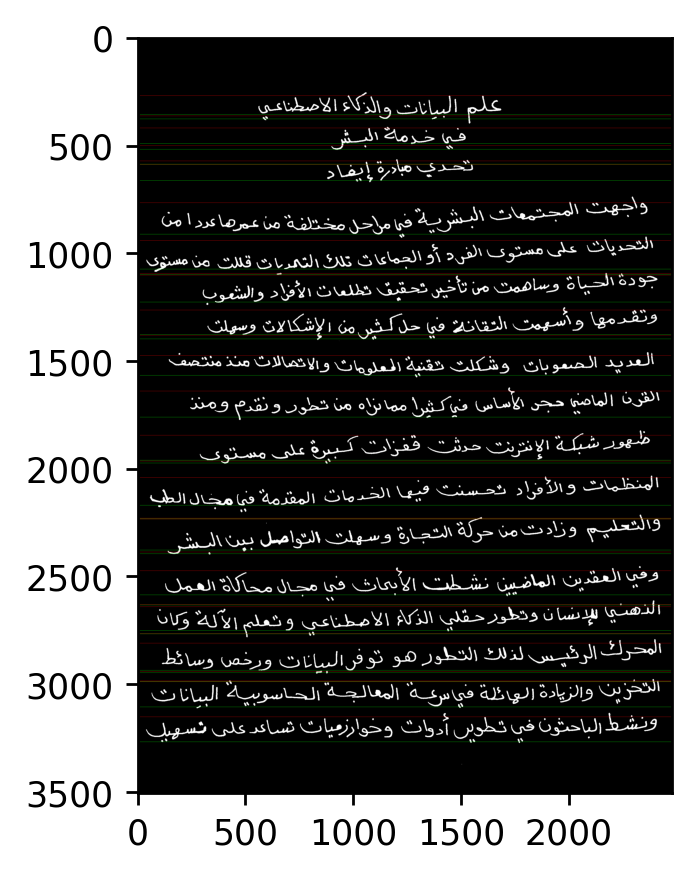

In [26]:
## (1) read
img = cv2.imread(train_dir + '/' + '005001003002-1.tiff')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## (2) threshold
th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)

## (3) minAreaRect on the nozeros
pts = cv2.findNonZero(threshed)
ret = cv2.minAreaRect(pts)

(cx,cy), (w,h), ang = ret
### Rotation is not needed for the time being
# print(ret)
# if w>h:
#     w,h = h,w
#     ang += 90 # orginal answer was rotating 90

ang = 0 # reset the angle of the minimum area box
## (4) Find rotated matrix, do rotation
M = cv2.getRotationMatrix2D((cx,cy), ang, 1.0)
rotated = cv2.warpAffine(threshed, M, (img.shape[1], img.shape[0]))

## (5) find and draw the upper and lower boundary of each lines
hist = cv2.reduce(rotated,1, cv2.REDUCE_AVG).reshape(-1)

th = 2
ImageHeight,ImageWidth = img.shape[:2]

uppers = [y for y in range(ImageHeight-1) if hist[y]<=th and hist[y+1]>th]
lowers = [y for y in range(ImageHeight-1) if hist[y]>th and hist[y+1]<=th]

rotated = cv2.cvtColor(rotated, cv2.COLOR_GRAY2BGR)
for y in uppers:
    cv2.line(rotated, (0,y), (ImageWidth, y), (255,0,0), 1)

for y in lowers:
    cv2.line(rotated, (0,y), (ImageWidth, y), (0,255,0), 1)


cv2.imwrite("result.png", rotated)
plt.imshow(rotated)

## Checking Line Segmentation Results
Lets check the number of lines identified by the algorithm and compare it with the actual numbre  

In [28]:
table = []
SizeOfLines = []
UpperLinesList = []
LowerLinesList = []

table.append(["Index","Upper","Lower","Size"])
for i, y in enumerate(uppers, start=0):   
    UpperLinesList.append(y)
    LowerLinesList.append(lowers[i])
    SizeOfLines.append(lowers[i]-y) # size of line = lower - upper
    table.append([i,y,lowers[i],lowers[i]-y])

display(HTML(tabulate.tabulate(table, tablefmt='html')))
  
# Printing average of the list 
print("Average of the list =", round(statistics.mean(SizeOfLines), 2)) 

Index,Upper,Lower,Size
0,267,354,87
1,361,375,14
2,417,489,72
3,499,516,17
4,570,585,15
5,586,661,75
6,764,910,146
7,939,1072,133
8,1092,1097,5
9,1100,1225,125


Average of the list = 70.17


The algorithem found `26` lines of code while the actual expected number is `17` lines of text.

There are more lines than expected this is caused by dots of Arabic letters and possibly noise depending on the quality of the image.

so we have to tweak the threshold and decide if the pixles in that identified line are part of the upper line ,lower line, or just noise.


In [29]:
# Reserved for figuring out how to fix the extra lines

# Cropping Lines of Text
Now that we found the upper and lower bounds of each line of text, we will crop the lines into multiple images correspoding to the number of lines


Line #1 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


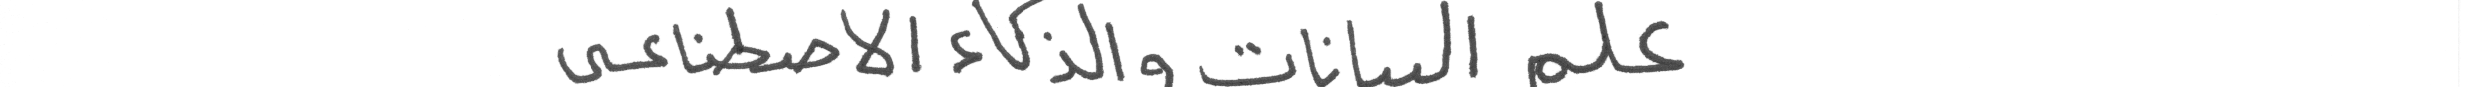

Line #2 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


Line #3 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


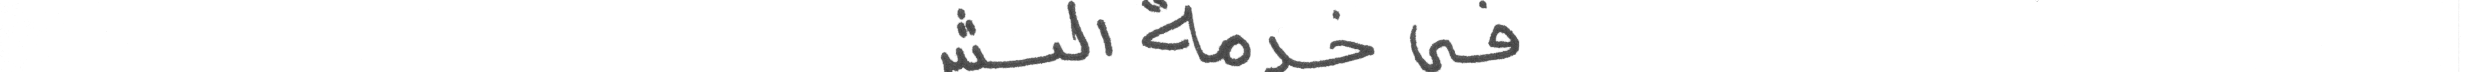

Line #4 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


Line #5 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


Line #6 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


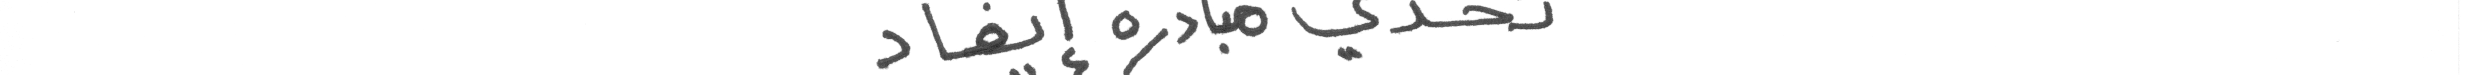

Line #7 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


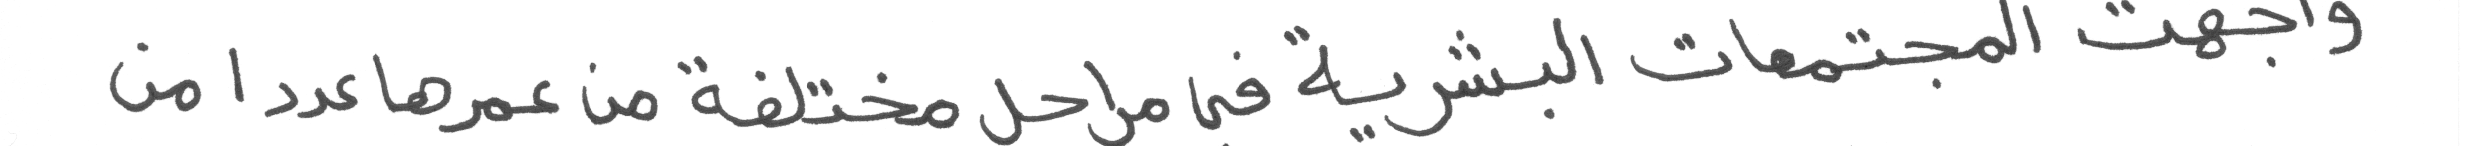

Line #8 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


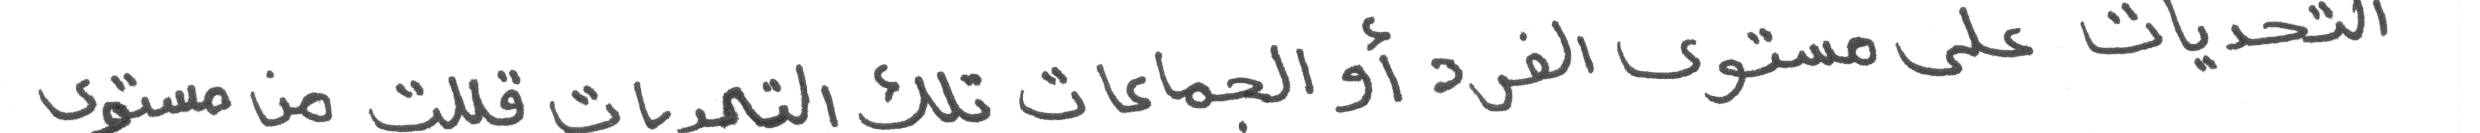

Line #9 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


Line #10 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


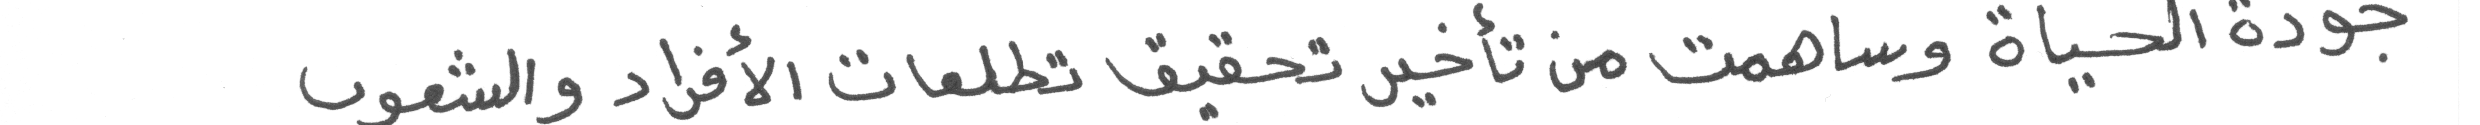

Line #11 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


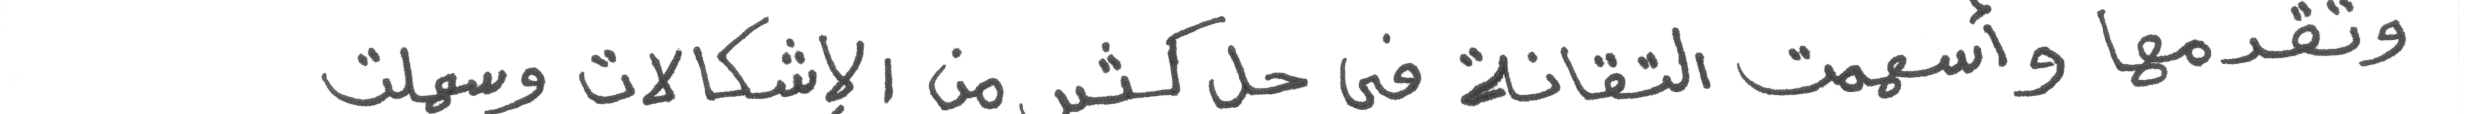

Line #12 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


Line #13 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


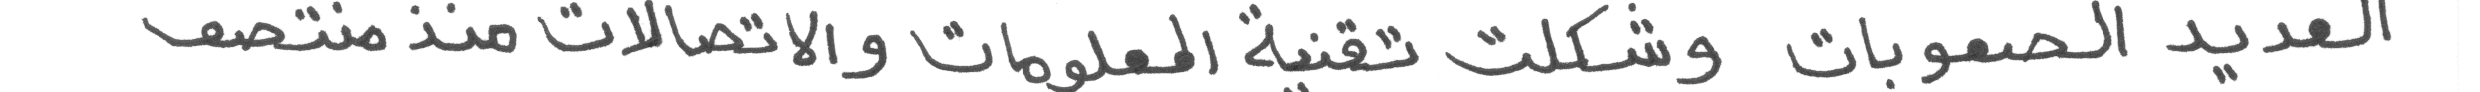

Line #14 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


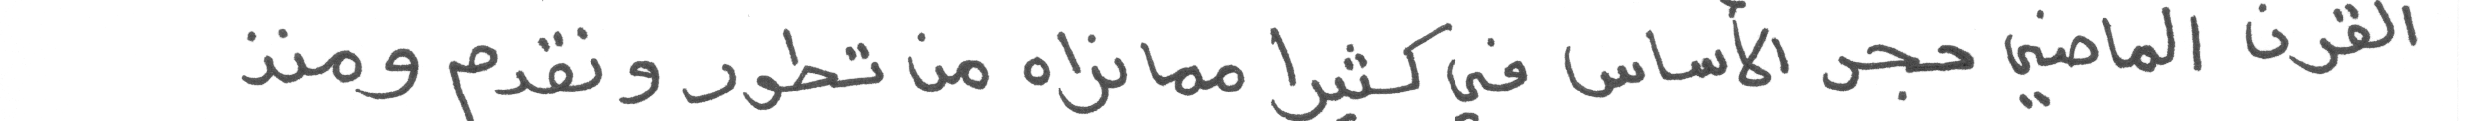

Line #15 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


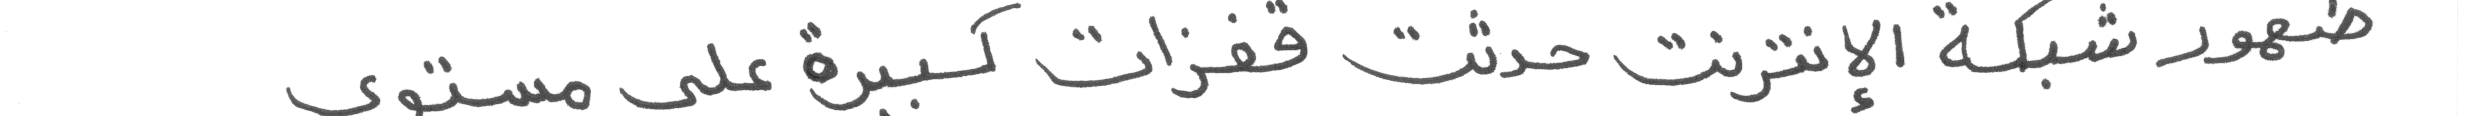

Line #16 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


Line #17 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


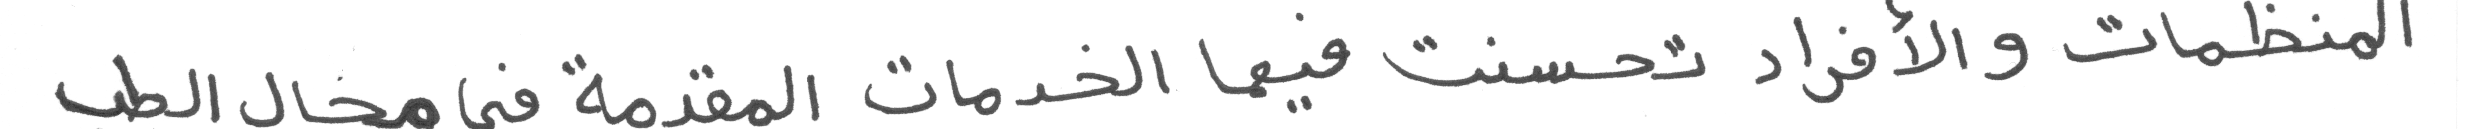

Line #18 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


Line #19 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


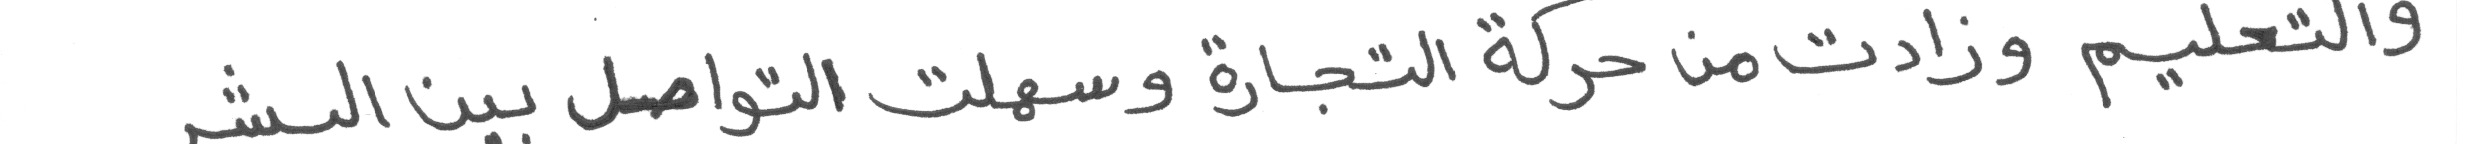

Line #20 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


Line #21 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


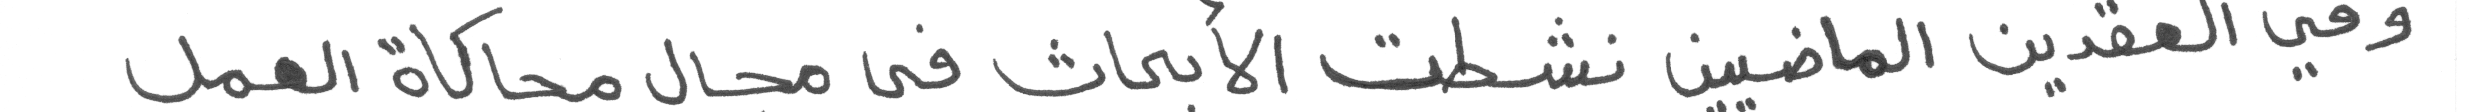

Line #22 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


Line #23 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


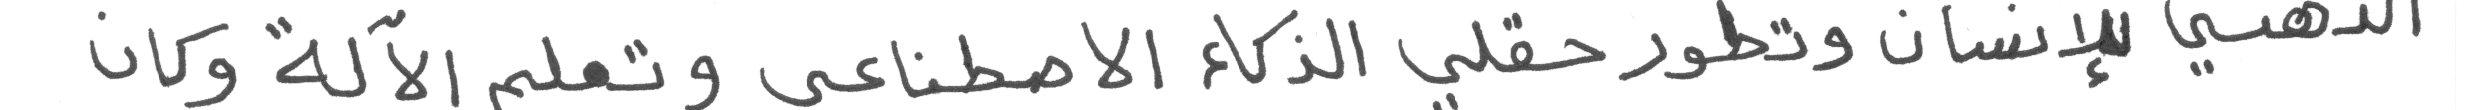

Line #24 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


Line #25 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


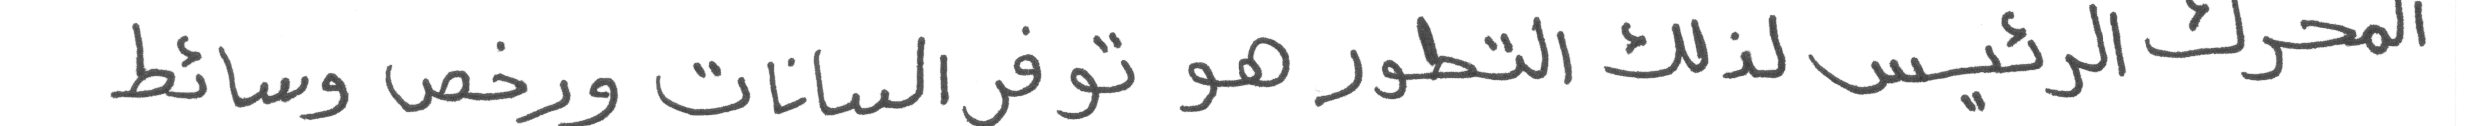

Line #26 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


Line #27 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


Line #28 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


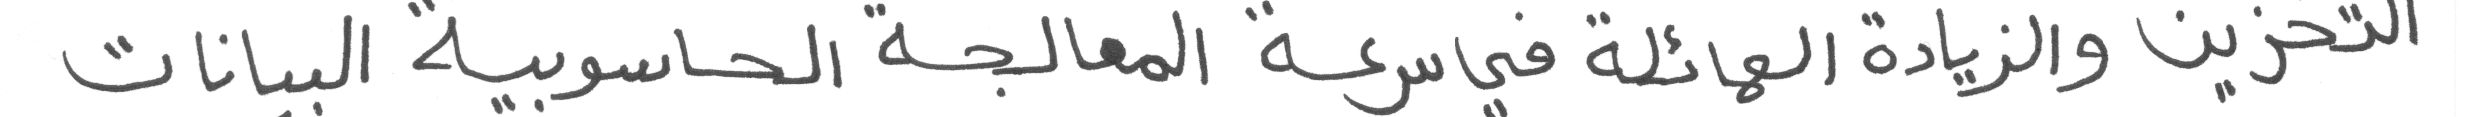

Line #29 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


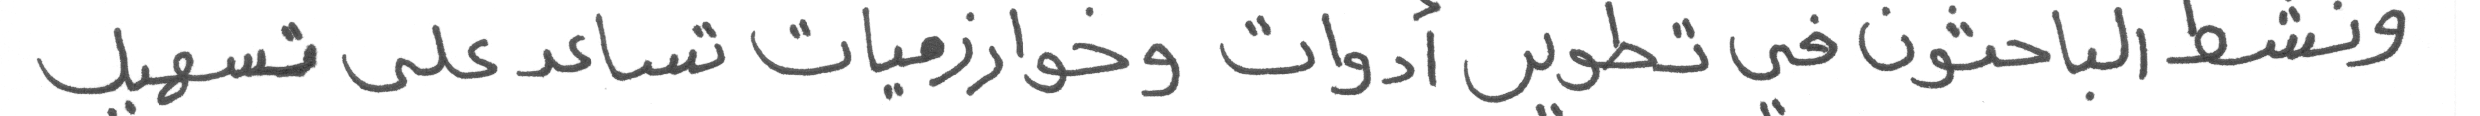

In [30]:
OriginalImage = ImagePIL.open(train_dir + '/' + '005001003002-1.tiff')

for i, y in enumerate(UpperLinesList, start=0):   
    img_left = OriginalImage.crop((0, y, ImageWidth, LowerLinesList[i]))
    print("Line #{} ---------------------------------------------------------------------------------------------------------------------------------------------------------------------".format(i+1))
    display(img_left)

#img_left.save("LastLine.png") 

# Seperating The Words in Each Line
Now that we have the lines, we can start seperating the words. We choose 2 solutions to this problem and decided to go with the second approch.


## Approch 1: Finding all Contours without minmum size

##### In this approch we used OpenCV to find the Contours (continous pixels) in the image regardless of the size of the pixels found.
---
Credits:
Part of the solution below was copied from 
https://stackoverflow.com/a/49597918/4017847

-1

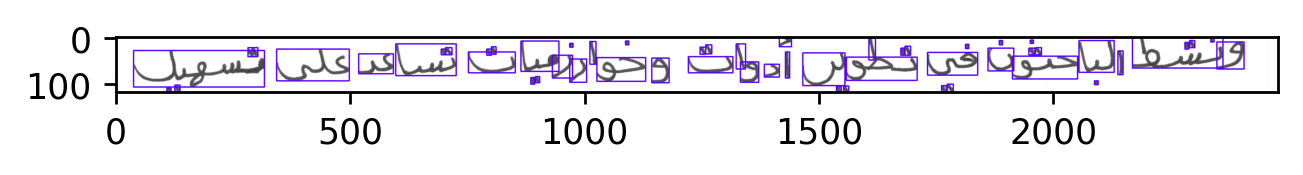

In [31]:
#read image
img = cv2.imread(train_dir + '/' + 'LastLine.png')

#grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cv2.waitKey(0)

#binarize 
ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
cv2.waitKey(0)

#find contours
ctrs, hier = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#sort contours
sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

for i, ctr in enumerate(sorted_ctrs):
    # Get bounding box
    x, y, w, h = cv2.boundingRect(ctr)

    # Getting ROI
    roi = img[y:y+h, x:x+w]

    # show ROI
    cv2.rectangle(img,(x,y),( x + w, y + h ),(90,0,255),2)
    cv2.waitKey(0)

#cv2.imshow('marked areas',img)
plt.imshow(img)
cv2.waitKey(0)

As you can see from the image above, OpenCv did a great job in finding the Centors. But one issue is that the dots and parts of the word are considered different words while our target is to crop the image whole for the time being. 

We will keep this approch as it's very powerful if it will seperate the word into parts so we can do OCR on the part seperatly. 

The dots and any close Contours can be merged into one Contour but carfuly as to not include the noise or combine words that shouldn't be combined

# Approch 2: Defnine a more complex funciton that will join the Contours 


In [32]:
import math
import cv2
import numpy as np


def wordSegmentation(img, kernelSize=25, sigma=11, theta=7, minArea=0):
	"""Scale space technique for word segmentation proposed by R. Manmatha: http://ciir.cs.umass.edu/pubfiles/mm-27.pdf
	
	Args:
		img: grayscale uint8 image of the text-line to be segmented.
		kernelSize: size of filter kernel, must be an odd integer.
		sigma: standard deviation of Gaussian function used for filter kernel.
		theta: approximated width/height ratio of words, filter function is distorted by this factor.
		minArea: ignore word candidates smaller than specified area.
		
	Returns:
		List of tuples. Each tuple contains the bounding box and the image of the segmented word.
	"""

	# apply filter kernel
	kernel = createKernel(kernelSize, sigma, theta)
	imgFiltered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
	(_, imgThres) = cv2.threshold(imgFiltered, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
	imgThres = 255 - imgThres

	# find connected components. OpenCV: return type differs between OpenCV2 and 3
	if cv2.__version__.startswith('3.'):
		(_, components, _) = cv2.findContours(imgThres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	else:
		(components, _) = cv2.findContours(imgThres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

	# append components to result
	res = []
	for c in components:
		# skip small word candidates
		if cv2.contourArea(c) < minArea:
			continue
		# append bounding box and image of word to result list
		currBox = cv2.boundingRect(c) # returns (x, y, w, h)
		(x, y, w, h) = currBox
		currImg = img[y:y+h, x:x+w]
		res.append((currBox, currImg))

	# return list of words, sorted by x-coordinate
	return sorted(res, key=lambda entry:entry[0][0])


def prepareImg(img, height):
	"""convert given image to grayscale image (if needed) and resize to desired height"""
	assert img.ndim in (2, 3)
	if img.ndim == 3:
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	h = img.shape[0]
	factor = height / h
	return cv2.resize(img, dsize=None, fx=factor, fy=factor)


def createKernel(kernelSize, sigma, theta):
	"""create anisotropic filter kernel according to given parameters"""
	assert kernelSize % 2 # must be odd size
	halfSize = kernelSize // 2
	
	kernel = np.zeros([kernelSize, kernelSize])
	sigmaX = sigma
	sigmaY = sigma * theta
	
	for i in range(kernelSize):
		for j in range(kernelSize):
			x = i - halfSize
			y = j - halfSize
			
			expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
			xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
			yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)
			
			kernel[i, j] = (xTerm + yTerm) * expTerm

	kernel = kernel / np.sum(kernel)
	return kernel

## prepare the image and find number of words using the current configuraitons

Segmented into 9 words


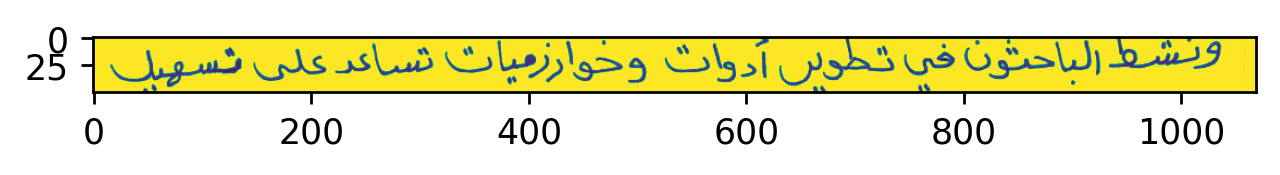

In [45]:
img = prepareImg(cv2.imread(train_dir + '/' + 'LastLine.png'), 50)
plt.imshow(img)
res = wordSegmentation(img, kernelSize=13, sigma=11, theta=7, minArea=100)
print('Segmented into %d words'%len(res))

## Crop the words and display the images

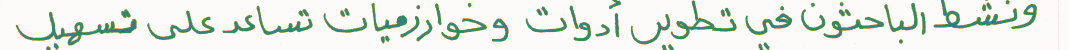

In [46]:
im = ImagePIL.fromarray(np.uint8(cm.gist_earth(img)*255))
display(im)

## Convert the prepared image to PIL and Specifiy font color

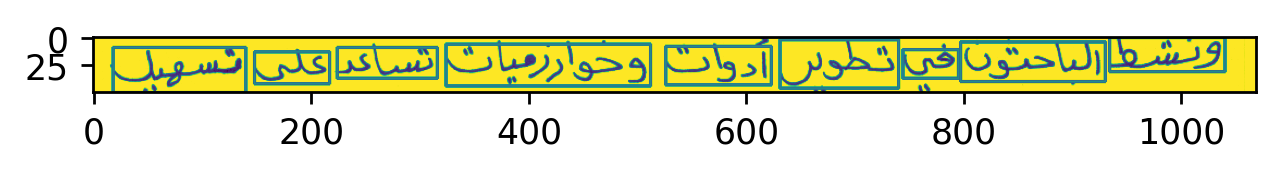

In [57]:
ExtractedWrodsList = []
for (j, w) in enumerate(res):
  (wordBox, wordImg) = w
  (x, y, w, h) = wordBox
  cv2.rectangle(img,(x,y),(x+w,y+h),(150, 111, 222),1) # draw bounding box in summary image
  img_left = im.crop((x, y, x+w, y+h))
  ExtractedWrodsList.append(img_left)

# output summary image with bounding boxes around words
plt.imshow(img)

# Cropping The Words From The Image
Now that we have identifed the words in the image, we can crop them and save them

---------------------------------------------------


---------------------------------------------------


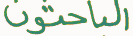

---------------------------------------------------


---------------------------------------------------


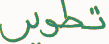

---------------------------------------------------


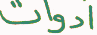

---------------------------------------------------


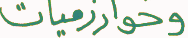

---------------------------------------------------


---------------------------------------------------


---------------------------------------------------


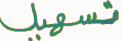

In [58]:
ExtractedWrodsList.reverse()
for (j, w) in enumerate(ExtractedWrodsList):
  print("---------------------------------------------------")
  display(w)
